In [1]:
# Import python libraries (pytorch, numpy, etc -- whatever you need to import)
import torch
import torch.nn as nn
import numpy as np
import scipy
import string
import random
import matplotlib.pyplot as plt
import glob

In [2]:
# Hyper parameters

torch.set_num_threads(4) # make it use upto 4 cpus -- to avoid utilizing all CPUs on master node when you run this script on master

BATCH_SIZE = 100 # number of batches
CROP_SIZE = 64 # If input protein is longer than CROP_SIZE, it will be trimed to have CROP_SIZE residues (i_start:i_start+CROP_SIZE)
AA_ORDER = "ARNDCQEGHILKMFPSTWYVX-"
DIVISOR = [1, 2, 5]
device="cuda:0" if torch.cuda.is_available() else "cpu" # which device to use?
print (device)

cpu


In [3]:
class CustomDataset(torch.utils.data.Dataset): 
    def __init__(self, list_name):
        self.root = "/public_data/ml/CATH40/CATH40-20JUN08/" # home directory for dataset
        self.domIDs = [line.strip() for line in open("%s/%s"%(self.root, list_name))] # items in dataset
        
        self.msa_dir = "%s/msa"%self.root # where can I find msa?
        self.ccm_dir = "%s/ccm"%self.root # where can I find raw CCM data (coevolution analysis)?
        self.pdb_dir = "%s/pdb"%self.root # where can I find ground-truth structure?
        
    def __len__(self):
        return len(self.domIDs)
    
    def read_MSA(self, msa_fn):
        table = str.maketrans(dict.fromkeys(string.ascii_lowercase))
        
        msa = list()
        with open(msa_fn) as fp:
            for line in fp:
                # skip labels
                if line[0] != '>':
                    # remove whitespaces/lowercase letters and append to MSA
                    msa.append(line.strip().translate(table))
            
        # convert letters into numbers
        alphabet = np.array(list(AA_ORDER), dtype='|S1').view(np.uint8) # (22)
        msa = np.array([list(s) for s in msa], dtype='|S1').view(np.uint8) # (Nseq, L)
        for i in range(alphabet.shape[0]):
            msa[msa == alphabet[i]] = i

        # treat all unknown characters as UNKNOWN
        msa[msa >= 22] = 20
            
        msa_onehot = np.eye(22)[msa] # one-hot encoded msa (Nseq, Length, 22)
        seq_onehot = msa_onehot[0] # one-hot encoded query sequence (Length, 22)
        seq_profile = msa_onehot.sum(axis=0) / msa_onehot.shape[0] # MSA sequence profile (Length, 22)

        return seq_onehot, seq_profile
        
    def read_pdb(self, pdb_fn, L):
        cords = list()
        seqnums = list()
        with open(pdb_fn) as fp:
            for line in fp:
                if line.startswith("ATOM"):
                    resName = line[17:20].strip()
                    atmName = line[12:16].strip()
                    resSeqN = line[23:26].strip()
                    if resName == "GLY":
                        if atmName == "CA":
                            cords.append([float(line[30:38]), float(line[38:46]), float(line[46:54])])
                            seqnums.append(int(resSeqN) - 1)
                    else:
                        if atmName == "CB":
                            cords.append([float(line[30:38]), float(line[38:46]), float(line[46:54])])
                            seqnums.append(int(resSeqN) - 1)
        cords = np.array(cords)

        Cb_dist = scipy.spatial.distance.cdist(cords, cords)
        Cb_contact = (Cb_dist < 8.0).astype(float) # Cb-Cb contact map (Ca for Gly) (Length, Length)
        
        # In PDB, it can have a missing region (exists in sequence, but not in structure).
        # I will use this during loss calculation.
        missing_res = list()

        for i in range(L):
            if i not in seqnums:
                Cb_contact = np.insert(Cb_contact, i, np.zeros((1, Cb_contact.shape[1])), axis=0)
                Cb_contact = np.insert(Cb_contact, i, np.zeros(1), axis=1)
                missing_res.append(i)

        mask = np.ones((L, L))
        mask[missing_res, :] = 0
        mask[:, missing_res] = 0
        
        return torch.from_numpy(Cb_contact), torch.from_numpy(mask)
        
    def __getitem__(self, idx):
        domain = self.domIDs[idx]
        msa_fn = "%s/%s.a3m"%(self.msa_dir, domain) # msa file for selected domain
        ccm_fn = "%s/%s.npy"%(self.ccm_dir, domain) # raw ccm file for selected domain
        pdb_fn = "%s/%s.pdb"%(self.pdb_dir, domain) # raw pdb file for selected domain
         
        # 1. read MSA & get query sequence + sequence profile & concatenate them to get a 1D feature
        feat_1d = np.concatenate(self.read_MSA(msa_fn), axis=-1) # (Length, 22+22)
        L = feat_1d.shape[0]
        
        # 2. tile them to make it as 2D feature
        tile_x = np.tile(feat_1d, (L, 1, 1))
        tile_y = np.transpose(tile_x, (1, 0, 2))

        # 3. read raw CCM (coevolution) data & get 2D input features by concatenating CCM features & tiled 1D features
        ccm = np.load(ccm_fn)
        feat_2d = torch.from_numpy(np.concatenate((ccm, tile_x, tile_y), axis=-1)) # (L, L, 441+44+44)
        
        # 4. read pdb & get contacts between Cb atoms (for Gly use Ca instead of Cb)
        labels, mask = self.read_pdb(pdb_fn, L)
        
        # 5. return input features, labels (contact map), and mask information (to calculate loss on valid pairs only)
        return feat_2d, labels, mask

In [4]:
# You need to define a rule about how to collate batch when proteins have different length
# Below is the example. feel free to modify it or use it as-is
def collate_batch(batch):
    # Input: batch = (input_feat, label, mask)
    # Output: Cropped input_feat, label, mask
    L_min = min([CROP_SIZE, min([input_feat.shape[0] for (input_feat,_,_) in batch])])
    
    b_input = list()
    b_label = list()
    b_mask = list()
    # crop examples having length > L_min
    for input_feat, label, mask in batch:
        L = input_feat.shape[0]
        if L > L_min:
            end_idx_1 = np.random.randint(L_min, L)
            end_idx_2 = end_idx_1
        else:
            end_idx_1 = L_min
            end_idx_2 = L_min
        b_input.append(input_feat[end_idx_1-L_min:end_idx_1,end_idx_2-L_min:end_idx_2])
        b_label.append(label[end_idx_1-L_min:end_idx_1,end_idx_2-L_min:end_idx_2])
        b_mask.append(mask[end_idx_1-L_min:end_idx_1,end_idx_2-L_min:end_idx_2])
    return torch.stack(b_input), torch.stack(b_label), torch.stack(b_mask)

In [5]:
# define dataloader for training set, validation set
traindata = CustomDataset("train_s") # (10251,)
data_size = len(traindata)

np.random.seed(516)
shuffled_indices = np.random.permutation(data_size)
#train_indices = shuffled_indices[:int(data_size * 0.8)]
#valid_indices = shuffled_indices[int(data_size * 0.8):]
train_indices = shuffled_indices[:4]
valid_indices = shuffled_indices[4:5]

trainset = torch.utils.data.Subset(traindata, train_indices)
validset = torch.utils.data.Subset(traindata, valid_indices)
testdata = CustomDataset("test_s") # (100,)
testset = testdata

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True, collate_fn=collate_batch)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False, collate_fn=collate_batch)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=False, collate_fn=collate_batch)

In [10]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer = self._make_layer(in_channels + i * growth_rate, growth_rate)
            self.layers.append(layer)

    def _make_layer(self, in_channels, out_channels):
        layer = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        )
        return layer

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_feature = layer(torch.cat(features, dim=1))
            features.append(new_feature)
        return torch.cat(features, dim=1)

class ContactPredictor(nn.Module):
    def __init__(self, d_in, d_out, num_blocks, growth_rate=32):
        super(ContactPredictor, self).__init__()
        self.growth_rate = growth_rate
        self.dense_blocks = nn.ModuleList()
        self.transition_layers = nn.ModuleList()

        # declare d_middle inside DenseNet (!=ResNet)
        d_middle = growth_rate * 2

        # Embedding layer
        self.embedding = nn.Conv2d(d_in, d_middle, 1) # project down d_in inputs to gr*2 hidden representation
        self.bn1 = nn.BatchNorm2d(d_middle)
        self.relu = nn.ReLU(inplace=True)

        # DenseNet
        for i, num_layers in enumerate(num_blocks):
            block = DenseBlock(d_middle, growth_rate, num_layers)
            self.dense_blocks.append(block)
            d_middle += num_layers * growth_rate
            if i != len(num_blocks) - 1:
                transition = self._make_transition_layer(d_middle)
                self.transition_layers.append(transition)
                d_middle //= 2
                
        # Mapping to output dimension
        self.to_out = nn.Conv2d(1152, d_out, kernel_size=1)
        
    def _make_transition_layer(self, in_channels):
        transition = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=1),
            nn.AdaptiveAvgPool2d((64, 64)),
        )
        return transition

    def forward(self, x):
        # Input: raw 2D features (Batch, d_raw, Length, Length)
        # Output: distogram/contact logits (Batch, n_bin, Length, Length)
        x = self.embedding(x)
        x = self.bn1(x)
        x = self.relu(x)
        for block, transition in zip(self.dense_blocks, self.transition_layers):
            x = block(x)
            x = transition(x)
        x = self.to_out(x)
        x = x.squeeze(1)
        return x

In [11]:
# 1. Training data -- Prepared
# 2. Data loader -- process input features & labels
# 3. Deep learning model
# 4. Optimizer
# 5. Loss function

# Get AI model to be trained
# You need to change **...** part!
# DenseNet-121: [6, 12, 24, 16]
# DenseNet-169: [6, 12, 32, 32]
# DenseNet-201: [6, 12, 48, 32]
# DenseNet-264: [6, 12, 64, 48]
model = ContactPredictor(529, 1, [6, 12, 64, 48]).to(device)

# define loss function to use (which loss you need to use?)
criterion = nn.BCEWithLogitsLoss()

In [12]:
# Search saved AI models for every epoch
SAVE_DIR = 'temp'
py_filename = 'HW3XX'

def get_epochs(filename):
    return int(filename.split('_')[-1][2:].split('.')[0])

def get_filename(epoch):
    return f'{SAVE_DIR}/model_{py_filename}_ep{epoch}.pth'

def best_model(epochs):
    best_epoch = 0
    best_labels = None
    best_outputs = None
    best_loss = 1.0
    
    for epoch in epochs:
        model.load_state_dict(torch.load(get_filename(epoch), map_location=torch.device('cpu'))['model_state_dict'])
        model.eval()
        avg_loss = 0.0
        with torch.no_grad(): # you don't need to calculate gradient for validation
            for i_batch, (inputs, labels, masks) in enumerate(testloader):
                inputs = inputs.permute(0,3,1,2).to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)
                outputs = model(inputs.float())
                loss = (criterion(outputs, labels)*masks).sum() / masks.sum()
                avg_loss += loss.detach()
            avg_loss = float(avg_loss / len(testloader))
        print(f'EP{epoch} | Loss: {avg_loss}')
        
        if avg_loss < best_loss:
            best_epoch = epoch
            best_loss = avg_loss
            best_labels = labels
            best_outputs = outputs
            
    return best_epoch, best_loss, best_labels, best_outputs

In [13]:
epochs = [get_epochs(x) for x in glob.glob(get_filename('*'))]
best_epoch, best_loss, best_labels, best_outputs = best_model(epochs)

EP1 | Loss: 0.12476204051451575
EP2 | Loss: 0.10742578356633434
EP3 | Loss: 0.10230530938150074
EP4 | Loss: 0.09929575837960834
EP5 | Loss: 0.11173942610885622
EP6 | Loss: 0.09896933341798442
EP7 | Loss: 0.10619323677922775
EP8 | Loss: 0.09103065892500027
EP9 | Loss: 0.09013604713802457
EP10 | Loss: 0.0945972052103514
EP11 | Loss: 0.09034548750493195
EP12 | Loss: 0.09164224870261625
EP13 | Loss: 0.0878881379274883
EP14 | Loss: 0.09152648848941493
EP15 | Loss: 0.08687059068557647
EP16 | Loss: 0.08558238843861059
EP17 | Loss: 0.08700816855254338
EP18 | Loss: 0.08603235884151779
EP19 | Loss: 0.08637632325025502
EP20 | Loss: 0.08280990784754785
EP21 | Loss: 0.07726284659907633
EP22 | Loss: 0.08106409777042665
EP23 | Loss: 0.08582404771633077
EP24 | Loss: 0.08104869675850725
EP25 | Loss: 0.08552500161668262
EP26 | Loss: 0.08429584170483066
EP27 | Loss: 0.0843863946495364
EP28 | Loss: 0.08457169563242294
EP29 | Loss: 0.07919279190526574
EP30 | Loss: 0.08642474922433732
EP31 | Loss: 0.0817804

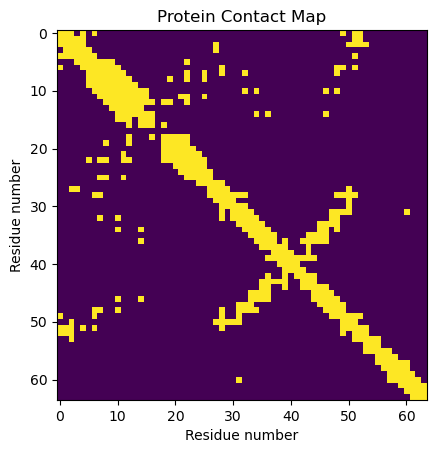

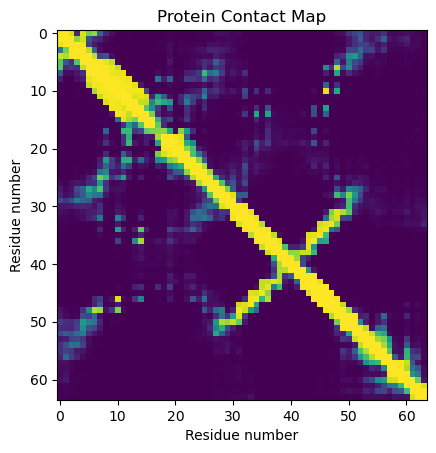

In [14]:
def visualize_map(contact_map):
    plt.imshow(contact_map, interpolation='none')
    plt.title('Protein Contact Map')
    plt.xlabel('Residue number')
    plt.ylabel('Residue number')
    plt.show()
    
visualize_map(best_labels[0])
visualize_map(torch.sigmoid(best_outputs[0]))

In [15]:
def precision(contacts, divisor):
    contacts = contacts[:len(contacts)//divisor]
    if len(contacts) == 0:
        return None
    return sum(row[1] for row in contacts)/len(contacts)

def contact_evaluator(prediction, label):
    predict_map = np.array(torch.sigmoid(prediction))

    short_range = []
    medium_range = []
    long_range = []

    for i in range(predict_map.shape[0]):
        for j in range(predict_map.shape[1]):
            if predict_map[i, j] >= 0.5:
                c_range = abs(i-j)
                if 6 <= c_range < 12:
                    short_range.append([predict_map[i, j], label[i, j]])
                elif 12 <= c_range < 24:
                    medium_range.append([predict_map[i, j], label[i, j]])
                elif 24 <= c_range:
                    long_range.append([predict_map[i, j], label[i, j]])

    short_range.sort(reverse=True)
    medium_range.sort(reverse=True)
    long_range.sort(reverse=True)
    
    result = np.zeros((3,3))
    for i, d in enumerate(DIVISOR):
        result[i, 0] = precision(short_range, d)
        result[i, 1] = precision(medium_range, d)
        result[i, 2] = precision(long_range, d)
    return result

def evaluate_all(predictions, labels):
    result = []
    for i in range(len(predictions)):
        result.append(contact_evaluator(predictions[i], labels[i]))
    
    stacked_result = np.stack(result)
    mean_result = np.nanmean(stacked_result, axis=0)
    return mean_result

best_result = evaluate_all(best_outputs, best_labels)

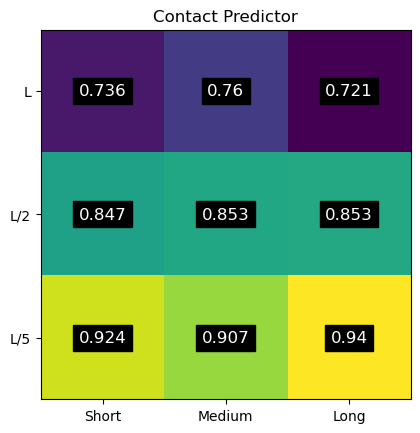

In [16]:
def visualize_result(result_matrix):
    plt.imshow(result_matrix, interpolation='none')
    plt.title('Contact Predictor')
    plt.xticks(np.arange(result_matrix.shape[1]), ['Short', 'Medium', 'Long'])
    plt.yticks(np.arange(result_matrix.shape[0]), ['L', 'L/2', 'L/5'])
    for i in range(result_matrix.shape[0]):
        for j in range(result_matrix.shape[1]):
            plt.text(j, i, str(round(result_matrix[i, j], 3)), ha='center', va='center', color='white', fontsize=12, bbox=dict(facecolor='black'))
    plt.show()

visualize_result(best_result)